# Exercise 10 - Metropolis Hastings Algorithm

In this exercise, we will denoise an image using Bayesian inference.

For this we will define prior and likelihood distributions and use them to sample from the posterior distribution using the Metropolis Hastings algorithm.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        22.01.2023
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=34630)

### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions, classes and other objects with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm is an algorithm to produce samples from any given target distribution.
All we need is a density function $p(x)$ *proportional* to the target distribution and a proposal function $q(x'|x)$ from which we can sample a new $x$.

For simplicity we here assume a symmetric proposal distribution, that is $q(x'|x) = q(x|x')$.
The algorithm then works as follows:

1. Initialize $x^{(t)}, t=0$
2. Sample $x'$ from $q(x'|x^{(t)})$
3. Calculate acceptance probability 
\begin{equation}
\alpha = \min\left(1, \cfrac{p(x')}{p(x)}\right)
\end{equation}
4. Set $x^{(t+1)} = x'$ with probability $\alpha$. Otherwise set $x^{(t+1)} = x^{(t)}$
5. Abort or $t = t+1$ and go to 2.

### Task 1

Implement the following function for a symmetric proposal distribution.

Use it to sample from a standard normal distribution given a start value of $x = -5$.
Check if the distribution of your samples is the desired standard normal distribution using the Kolmogorov-Smirnov test ($p=0.05$).

For numerical reasons you might consider using log-densities within the algorithm.

average: p = 0.7624975268708161


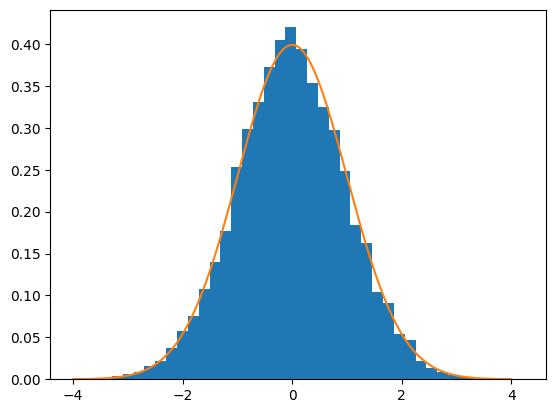

In [1]:
import itertools
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


def metropolis_hastings(X_start: object, prob_func: callable, proposal_func: callable, N: int, save_every: int = 1, seed: int = 0) -> np.ndarray:
    '''
    Given an (unnormalized) probability density function, returns samples with Metropolis-Hastings Algorithm.

    @Params:
        X_start... start value
        prob_func... function that returns something proportional to the target density for a given X
        proposal_func... function that returns a new X given the current X
        N... number of Metropolis Hasting steps
        save_every... for memory reasons we return only every k-th sample (and hope they are iid)

    @Returns:
        trace of samples from target distribution
    '''
    np.random.seed(seed)
    x_t = X_start
    samples = np.empty(N)
    # k = save_every - 1 (the highest possible value) indicates the value being saved
    for t in range(N):
        # sample k times
        for k in range(save_every):
            # propose a next x
            x_next = proposal_func(x_t)
            # see if it gets accepted
            # if p(x_next) is 0, it won't be accepted (let's spare numpy the log(0))
            if prob_func(x_next) == 0:
                continue
            log_a = min(0, np.log(prob_func(x_next)) - np.log(prob_func(x_t)))
            # u < a == log(u) < log(a)
            # np.random.uniform() is in [0, 1), 1 - np.random.uniform is in (0, 1]
            if np.log(1 - np.random.uniform()) < log_a:
                # accept the proposal
                x_t = x_next
        # after sampling k times, save the last sample
        samples[t] = x_t
    return samples


# TODO: sample and check distribution
# use shifted cauchy distribution for symmetric proposal function
proposal_func = lambda x: np.random.standard_cauchy() - x
prob_func = lambda x: np.exp(-x**2 / 2)

# test if it's standard normal distributed
save_every = 100
x_start = -5
n_runs = 10
n_samples_test = 100
p_values = [None] * n_runs
for run in range(n_runs):
    samples = metropolis_hastings(x_start, prob_func, proposal_func, n_samples_test, save_every)
    test_result = stats.kstest(samples, stats.norm.cdf)
    p_values[run] = test_result.pvalue
print(f"average: p = {np.average(p_values)}")

# plot the stuff maybe
n_samples_plot = 10000
samples = metropolis_hastings(x_start, prob_func, proposal_func, n_samples_plot, save_every)
x = np.linspace(-4, 4, 1000)
plt.hist(samples, bins=40, density=True)
plt.plot(x, prob_func(x) / np.sqrt(2 * np.pi))
plt.show()


# Bayesian Inference

In previous exercises we saw that sampling from a normal distribution is easy and therefore not the right application for the Metropolis-Hastings algorithm.

**Bayesian Inference** is the main field in which this algorithm is applied. 
Given some observed data and a target quantity $X$ we are interested in the posterior distribution
\begin{align}
p(X|\text{Data})&= \cfrac{p(\text{Data}|X)p(X)}{p(\text{Data})}
\end{align}

The denominator can become quite nasty, since
\begin{equation}
p(\text{Data}) = \int_{X'}p(\text{Data}|X')p(X') dX'
\end{equation}

it requires integrating over the whole space of $X$! We shall later see, that it is often intractable to do this.

This is where the Metropolis-Hastings algorithm comes in handy. Since we only need a density **proportional** to the target density and 

\begin{equation}
p(X|\text{Data})\propto p(\text{Data}|X)p(X)\,,
\end{equation}
all we need to do is to define **prior** and **likelihood**.


In Python, packages such as [PyMC3](https://docs.pymc.io/en/v3/index.html) are specifically designed to sample a vast amount of samples from a target posterior distribution. 

Here however we want to use *our* implementation to perform Bayesian Inference on the space of binary images.

## Image Denoising

Consider the space of $64\times64$ binary images, where each of the pixels is either 0 or 1. The whole space contains $2^{4096}$ possible images, which is far from being tractable to integrate over.

### Task 2

In `img_noise.npy` you find such an image. Load and display it.

In [ ]:
# TODO: load and display

As you can see, this image is quite noisy, in the sense that some of the bits are flipped.

We now want to apply the framework of Bayesian inference on the task of denoising the image:

Let $X$ be the observed image and $Z$ be the true underlying image. Then we are interested in the expected value of the posterior distribution

\begin{equation}
p(Z|X)\propto p(X|Z)p(Z)\,,
\end{equation}

that is the distribution of images given the noisy image. As described before, we need to specify two distributions: the prior $p(Z)$ and the likelihood $p(X|Z)$.

## Proposal function

In order to use the Metropolis-Hastings algorithm, we need a proposal function. In the case of binary images, we can simply flip a random bit. This way the proposal distribution is symmetric.

### Task 3

Implement the proposal function that flips a random bit in the binary image.

In [ ]:
def image_proposal(X:np.ndarray) -> np.ndarray:
    '''
    Proposal function for binary images.
    
    @Params:
        X... binary image
        
    @Returns:
        X with a random bit flipped.
    '''
    # TODO: implement
    pass

## Prior
The prior $p(Z)$ encodes how we imagine a "true" image looks like. Unusual images should get a low prior probability.

Here we want to use the simplified [Ising model](https://en.wikipedia.org/wiki/Ising_model) that essentially encodes the belief that a pixel has a similar bit to its neigbours.

Let $z_i$ be a pixel in a binary image $Z$ and $\mathcal{N}(i)$ denote the neighbouring pixels of $z_i$. The quantity 

\begin{equation}
H(Z) = -\sum_{i}\sum_{j\sim \mathcal{N}(i)}\sigma\left(z_i\right)\sigma\left(z_j\right)
\end{equation}
is called **energy** of the image, where
\begin{equation}
\sigma(x) = \begin{cases}
1&\text{, if }x = 1\\
-1&\text{, if }x = 0
\end{cases}\,.
\end{equation}

Random images have a high energy and images with large areas have a low energy (large negative number).

Thus we can define our prior as a density proportional to

\begin{equation}
p_\beta(Z) = \cfrac{\exp\left(-\beta H(Z)\right)}{\sum_{Z'}\exp\left(-\beta H(Z')\right)}\propto \exp\left(-\beta H(Z)\right)\,.
\end{equation}

We can ignore the normalization constant, since it can be multiplied with the normalization constant of the posterior to a new constant.


### Task 4

Implement the prior density function for the Ising model.

Use the Metropolis-Hastings algorithm to sample from the prior distribution and display an estimate for the expected value of the prior $\mathbb{E}_{p_{\beta}}(X)$ for various $\beta$.

In [ ]:
def energy(X:np.ndarray) -> float:
    '''
    Calculates energy of a given image.
    
    @Params:
        X... binary image
        
    @Returns:
        Energy as defined in the Ising model.
    '''
    # TODO: implement
    pass

def logprior(X:np.ndarray, beta:float):
    '''
    Calculates the (proportional) logdensity of the ising model prior.
    
    @Params:
        X... binary image
        beta... parameter of prior distribution
    '''
    # TODO: implement
    pass

# TODO: plot expected image for various beta

## Likelihood

The likelihood $p(X|Z)$ encodes our assumption on how the noisy image was generated from the original image.

Here we want to go with the simple assumption, that we flipped each pixel independently with a probability of $\pi$.

This means that the probability to have generated $X$ from $Z$ is simply

\begin{equation}
p(X|Z) = \pi^{\text{# pixels that are different}}(1-\pi)^{\text{# pixels that are same}}\,.
\end{equation}

### Task 5

Implement the loglikelihood density function below.

Use the Metropolis-Hastings algorithm to sample from the likelihood distribution and display an estimate for the expected value of the likelihood $\mathbb{E}_{p_{\pi}}(X|Z)$ for various $\pi$ (set $Z$ as the noisy image). 

In [ ]:
def loglikelihood(X, Z, pi):
    '''
    Calculates the logdensity of the categorical likelihood p(X|Z).
    
    @Params:
        X... binary image
        Z... binary image
        pi... parameter of likelihood distribution
    '''
    # TODO: implement
    pass

# TODO: plot expected image for various pi

## Posterior

Remember that our goal is to sample from the posterior distribution $p(Z|X)$. Now that we have the prior and the likelihood defined, we can define the posterior density.

### Task 6

Implement the posterior density function.

Use the Metropolis-Hastings algorithm to sample from the posterior distribution and display an estimate for the expected value of the posterior $\mathbb{E}_{p_{\pi, \beta}}(Z|X)$ for a reasonable choice of $\pi$ and $\beta$.

In [ ]:
def logposterior(X, Z, pi, beta):
    '''
    Calculates the (proportional) logdensity of the posterior p(Z|X).
    
    @Params:
        X... binary image
        Z... binary image
        pi... parameter of likelihood distribution
        beta... parameter of prior distribution
    '''
    # TODO: implement
    pass

# TODO: plot expected image